<a href="https://colab.research.google.com/github/zbiswas3/Machine_learning_gatech/blob/master/boosting_bank_marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve, validation_curve, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import  SimpleImputer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set(rc={'figure.figsize':(12,8.5)})
sns.set_context('poster', font_scale=0.75)


In [ ]:
np.random.seed(42)

## **Utils**

In [ ]:
# validatiion curve
def valid_plot(
    X, 
    y, 
    param_range, 
    param_name, 
    estimator, 
    xlabel="parameter", 
    ylabel="accuracy score",  
    title="Validation Curve",
    scoring="accuracy",
    ):
  train_scores, test_scores = validation_curve(
      estimator,
      X,
      y,
      param_name=param_name,
      param_range=param_range,
      scoring=scoring,
      # n_jobs=4,
      cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
  )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.ylim(0.0, 1.1)
  lw = 2
  plt.plot(
      param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
  )
  plt.fill_between(
      param_range,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.2,
      color="darkorange",
      lw=lw,
  )
  plt.plot(
      param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
  )
  plt.fill_between(
      param_range,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.2,
      color="navy",
      lw=lw,
  )
  plt.legend(loc="best")
  return plt


In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(26, 8))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [ ]:
# Calculate bias and variance of the model
def bias_var(y_test, y_pred):
    mean_predictions = np.mean(y_pred, axis=0)
    avg_bias = np.sum((mean_predictions - y_test)**2) / y_test.size
    avg_var = np.sum((mean_predictions - y_pred)**2) / y_pred.size

    return avg_var, avg_bias


## Data Source:



Fatih Ertam, fatih.ertam '@' firat.edu.tr, Firat University, Turkey.


Data Set Information:

There are 12 featur

```
# This is formatted as code
```

es in total. Action feature is used as a class. There are 4 classes in total. These are allow, action, drop and reset-both classes.


Attribute Information:

Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received


Relevant Papers:

F. Ertam and M. Kaya, â€œClassification of firewall log files with multiclass support vector machine,â€ in 6th International Symposium on Digital Forensic and Security, ISDFS 2018 - Proceeding, 2018.



Citation Request:

If you have no special citation requests, please leave this field blank.

## Data 

In [ ]:
%%capture
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
!unzip "bank-additional.zip"

## Data analysis

In [ ]:
data = pd.read_csv("bank-additional/bank-additional-full.csv", delimiter=";")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
data  = pd.concat([data[data.y=="yes"], data[data.y=="no"].sample(frac=0.3, random_state=42)])
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
75,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,1575,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
83,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,1042,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,1467,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
129,41,technician,married,professional.course,unknown,yes,no,telephone,may,mon,579,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
139,45,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,461,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes


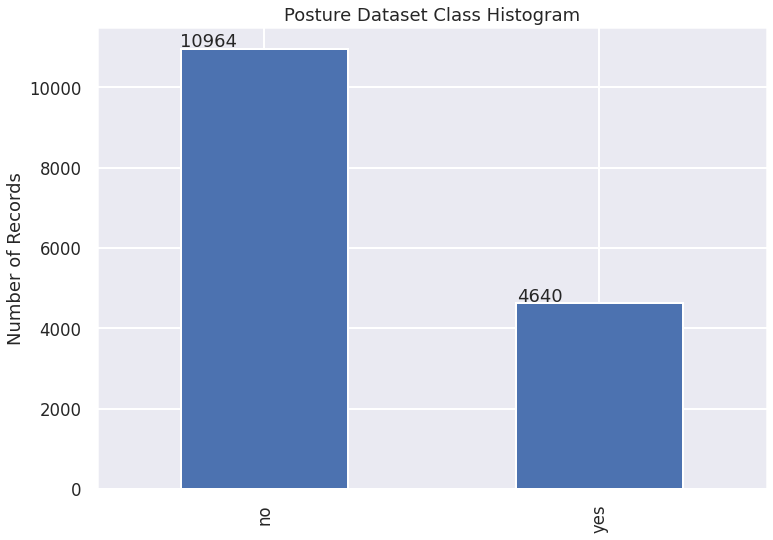

In [ ]:
ax = data.y.value_counts().plot(kind='bar')
try:
  ax.bar_label(ax.containers[0])
except:
  for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title("Posture Dataset Class Histogram")
plt.ylabel("Number of Records")
plt.show()

## Data preprocessing

In [ ]:
cat_columns = data.select_dtypes('object').columns.tolist()
for col in cat_columns:
  data[col] = data[col].astype('category').cat.codes
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
75,41,1,0,0,1,2,0,1,6,1,1575,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1
83,49,2,1,6,1,2,0,1,6,1,1042,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1
88,49,9,1,2,0,0,0,1,6,1,1467,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1
129,41,9,1,5,1,2,0,1,6,1,579,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1
139,45,1,1,2,1,2,0,1,6,1,461,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1


In [ ]:
data.y.value_counts()

0    10964
1     4640
Name: y, dtype: int64

## Data split

In [ ]:
# data = data[data.Action != 3]
X, X_test, y, y_test = train_test_split(data[data.columns[:-1]], data[data.columns[-1]].values, test_size=0.33, random_state=42)

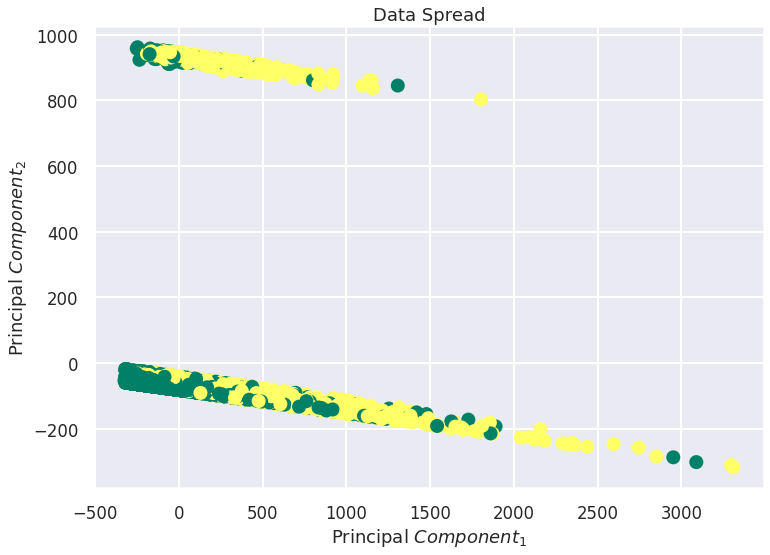

In [ ]:
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)
plot = plt.scatter(X_pca[:,0],X_pca[:,1], c=y, cmap='summer')
plt.xlabel(r"Principal $Component_1$")
plt.ylabel(r"Principal $Component_2$")
plt.title("Data Spread")
plt.show()

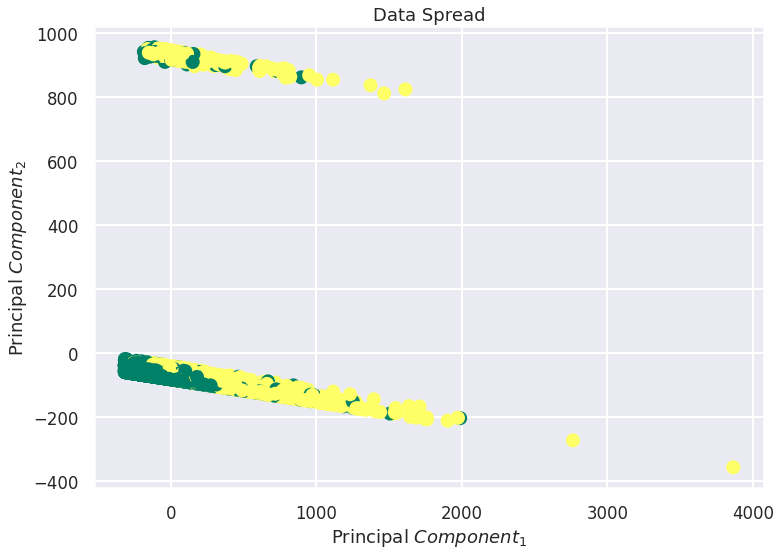

In [ ]:
X_pca = pca.transform(X_test)
plot = plt.scatter(X_pca[:,0],X_pca[:,1], c=y_test, cmap='summer')
plt.xlabel(r"Principal $Component_1$")
plt.ylabel(r"Principal $Component_2$")
plt.title("Data Spread")
plt.show()

# Adaboosting Classification


## Gridsearch cross validation

In [ ]:
%%time
dt_1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
dt_2 = DecisionTreeClassifier(criterion='entropy', max_depth=2)

model = AdaBoostClassifier(random_state=42)
# define the grid of values to search
grid = dict()
grid['base_estimator'] = [dt_1, dt_2]
grid['n_estimators'] = range(50, 301, 50)
grid['learning_rate'] = [1, 0.1]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_macro', verbose=10)
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 30 folds for each of 24 candidates, totalling 720 fits
Best: 0.857308 using {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=2), 'learning_rate': 0.1, 'n_estimators': 250}
0.830749 (0.011062) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 50}
0.831683 (0.012795) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 100}
0.833552 (0.012299) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 150}
0.835342 (0.012933) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 200}
0.835728 (0.013086) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 250}
0.836552 (0.012249) with: {'base_estimator': DecisionTreeClassifier(criterion

In [ ]:
%%time
dt_1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
dt_2 = DecisionTreeClassifier(criterion='entropy', max_depth=2)

model = AdaBoostClassifier(random_state=42)
# define the grid of values to search
grid = dict()
grid['base_estimator'] = [dt_1, dt_2]
grid['n_estimators'] = range(50, 301, 50)
grid['learning_rate'] = [1, 0.1, 0.01]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose=10)
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 30 folds for each of 36 candidates, totalling 1080 fits
Best: 0.879790 using {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=2), 'learning_rate': 0.1, 'n_estimators': 250}
0.862731 (0.008676) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 50}
0.863623 (0.009778) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 100}
0.865026 (0.009213) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 150}
0.866238 (0.009753) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 200}
0.866398 (0.009798) with: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1), 'learning_rate': 1, 'n_estimators': 250}
0.867004 (0.009335) with: {'base_estimator': DecisionTreeClassifier(criterio

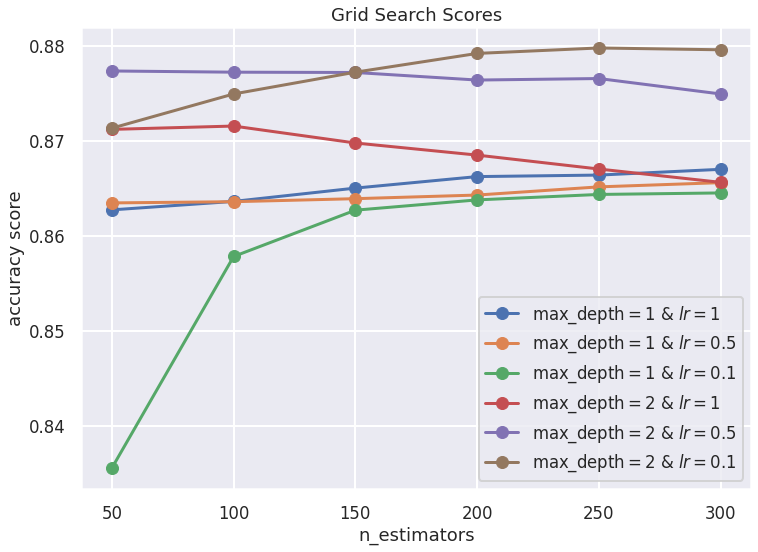

In [ ]:
plt.plot(
    list(grid["n_estimators"]),np.array(means).reshape((-1, 6)).T, 'o-',)
plt.legend([f"max_depth$={d}$ & $lr={l}$" for d in [1,2] for l in grid["learning_rate"]])
plt.title("Grid Search Scores")
plt.xlabel("n_estimators")
plt.ylabel("accuracy score")
plt.show()

## Validation Curve

In [ ]:
estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=2), learning_rate=0.1)

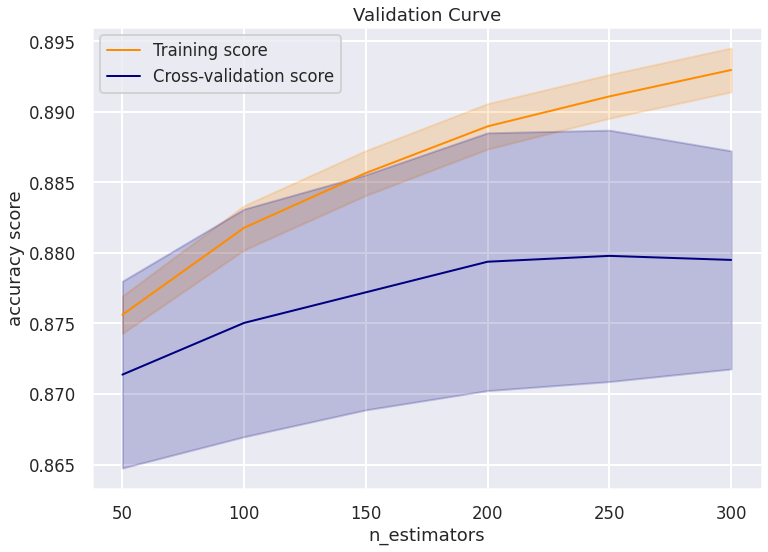

CPU times: user 8min 48s, sys: 3.11 s, total: 8min 51s
Wall time: 8min 56s


In [ ]:
%%time
valid_plot(    
    X, 
    y, 
    param_range=range(50, 301, 50), 
    param_name='n_estimators', 
    estimator=estimator,
    xlabel="n_estimators",
    )
plt.show()

In [ ]:
estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1), learning_rate=0.1)

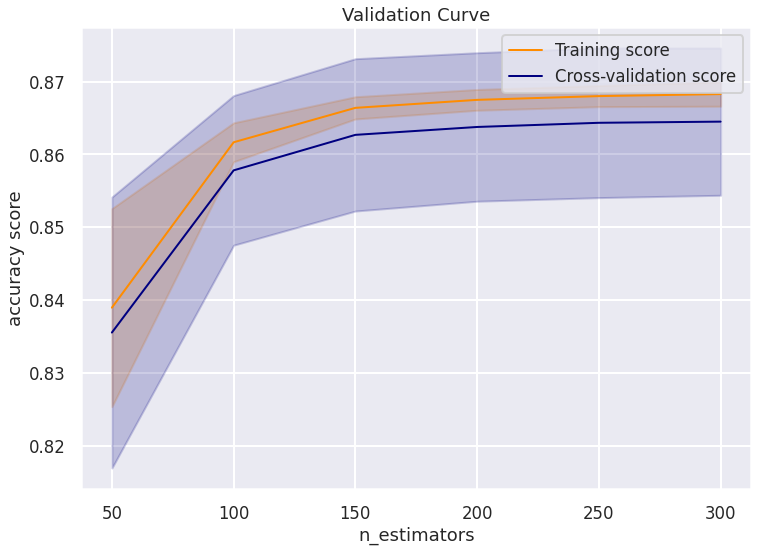

CPU times: user 6min 7s, sys: 2.83 s, total: 6min 10s
Wall time: 6min 9s


In [ ]:
%%time
valid_plot(    
    X, 
    y, 
    param_range=range(50, 301, 50), 
    param_name='n_estimators', 
    estimator=estimator,
    xlabel="n_estimators",
    )
plt.show()

In [ ]:
estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=2), n_estimators=250)

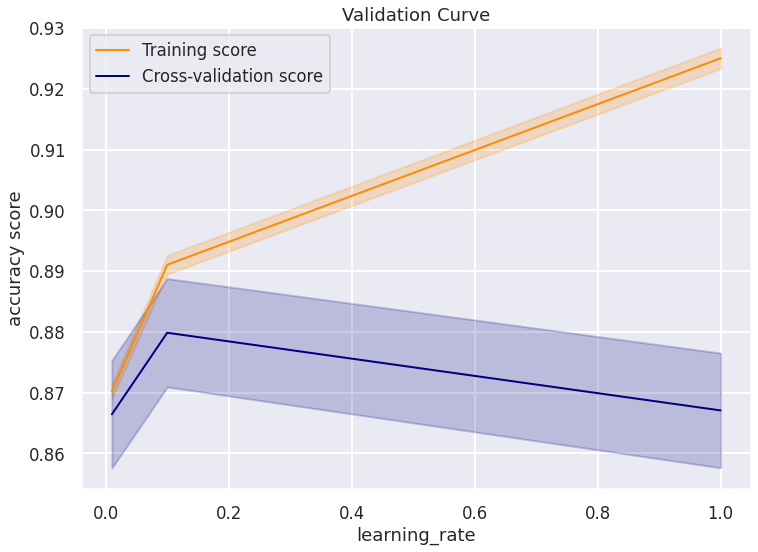

CPU times: user 6min 7s, sys: 3.74 s, total: 6min 10s
Wall time: 6min 9s


In [ ]:
%%time
valid_plot(    
    X, 
    y, 
    param_range=[0.01, 0.1, 1 ], 
    param_name='learning_rate', 
    estimator=estimator,
    xlabel="learning_rate",
    )
plt.show()

In [ ]:
estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1), learning_rate=0.01)

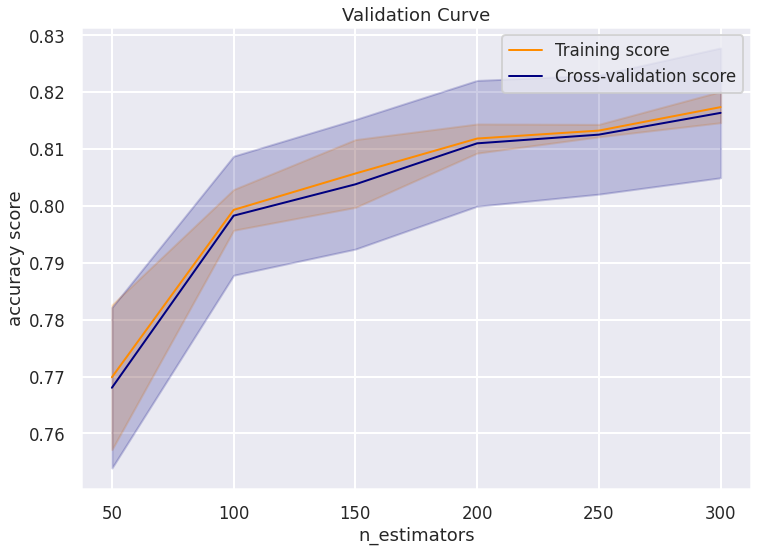

CPU times: user 6min 13s, sys: 7.75 s, total: 6min 20s
Wall time: 6min 20s


In [ ]:
%%time
valid_plot(    
    X, 
    y, 
    param_range=range(50, 301, 50), 
    param_name='n_estimators', 
    estimator=estimator,
    xlabel="n_estimators",
    )
plt.show()

## Final estimator design

## Learning Curves

In [ ]:
estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=2), n_estimators=250, learning_rate=0.1)

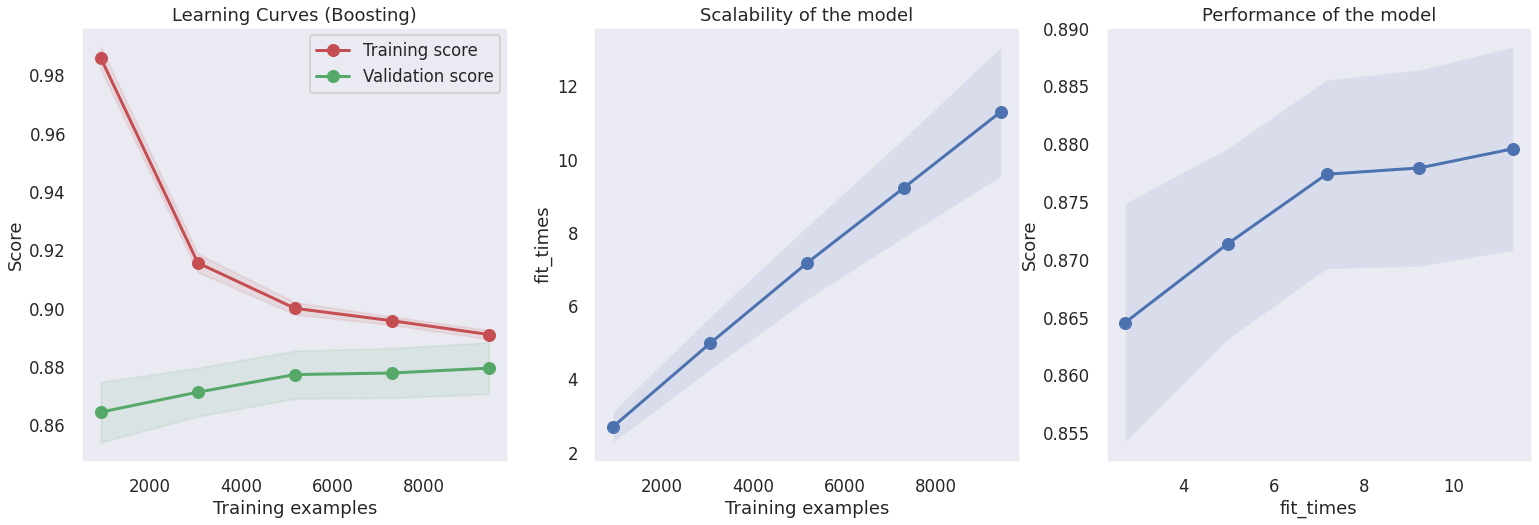

CPU times: user 3.96 s, sys: 413 ms, total: 4.37 s
Wall time: 5min 19s


In [ ]:
%%time
title = "Learning Curves (Boosting)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4
)

plt.show()

In [ ]:
estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1), n_estimators=250, learning_rate=0.01)

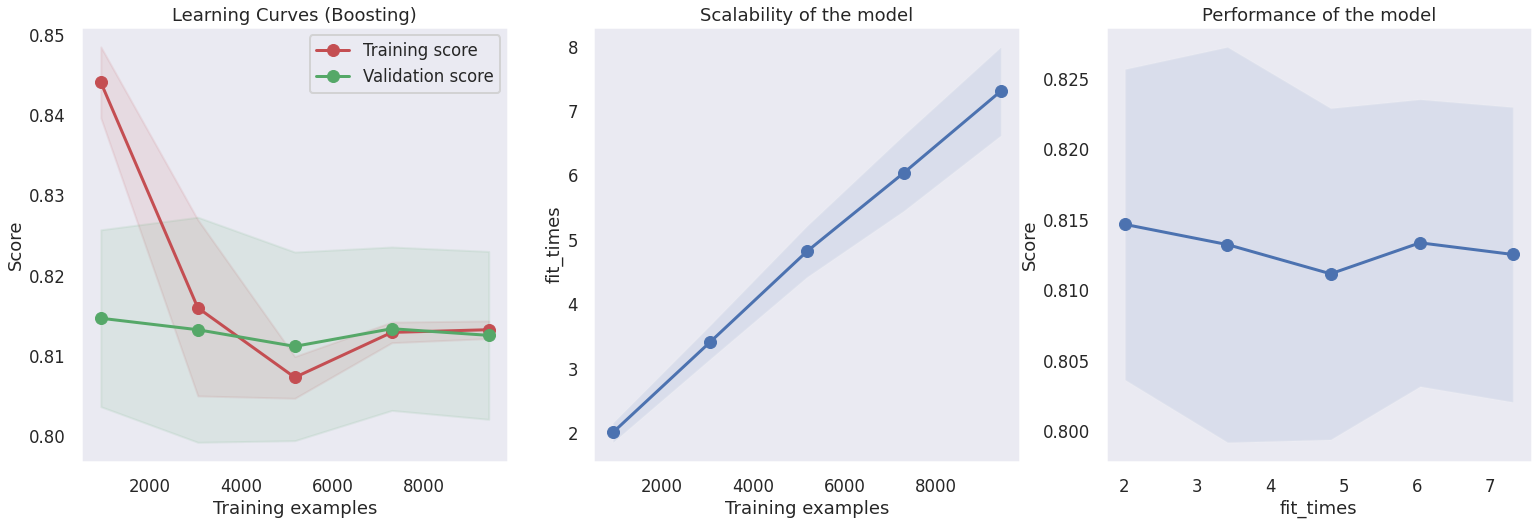

CPU times: user 3.51 s, sys: 378 ms, total: 3.89 s
Wall time: 3min 47s


In [ ]:
%%time
title = "Learning Curves (Boosting)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4
)

plt.show()

## Prediction and accuracy

In [ ]:
estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=2), n_estimators=250, learning_rate=0.1)

In [ ]:
%%time
estimator.fit(X, y)

CPU times: user 3.47 s, sys: 11.2 ms, total: 3.48 s
Wall time: 3.47 s


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=2),
                   learning_rate=0.1, n_estimators=250)

In [ ]:
%%time
y_pred = estimator.predict(X_test)

CPU times: user 256 ms, sys: 768 µs, total: 256 ms
Wall time: 255 ms


In [ ]:
print("Training Score:", estimator.score(X, y))
print("Testing Score:", estimator.score(X_test, y_test))


Training Score: 0.8903768892290033
Testing Score: 0.876504854368932


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3617
           1       0.78      0.82      0.80      1533

    accuracy                           0.88      5150
   macro avg       0.85      0.86      0.85      5150
weighted avg       0.88      0.88      0.88      5150



## Confusion Matrix

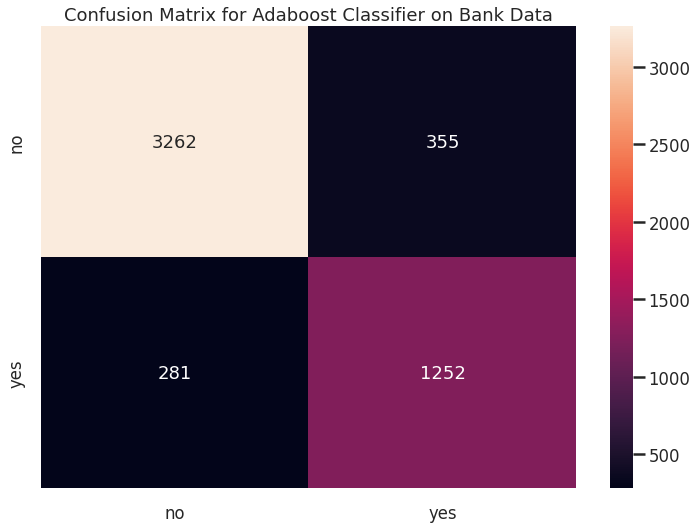

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.title("Confusion Matrix for Adaboost Classifier on Bank Data")
plt.show()

## Bias, variance, and error score

In [ ]:
bias_var(y_test, y_pred)

(0.21467060043359418, 0.2092689980205486)

In [ ]:
mean_squared_error(y_test, y_pred)

0.12349514563106796